In [1]:
import sys
import os

# append to path root dir
sys.path.append('../')

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import dataset
import importlib

In [53]:
import dataset
importlib.reload(dataset)

<module 'dataset' from 'g:\\Dev\\AI\\Projects\\ImageGeneration\\dataset.py'>

In [54]:
dataset = dataset.AudiAutoregressionGrayscale24px()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

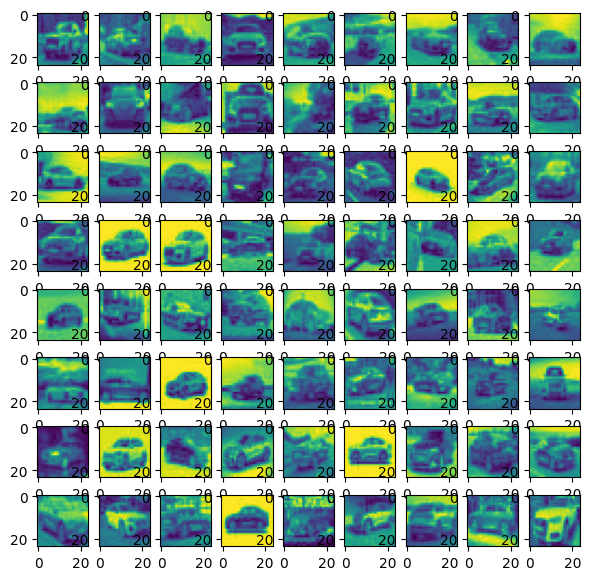

In [17]:
# show 16 images from data set
fig, axs = plt.subplots(8, 9, figsize=(7, 7))
for i in range(8):
    for j in range(9):
        image = dataset.without_mask(i*9+j)
        axs[i][j].imshow(image.view(24, 24, 1).numpy())

#fig.savefig("./results/autoregressor_dataset_of_72_images.jpg")

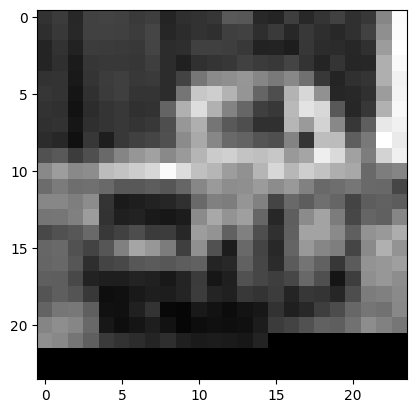

In [34]:
sample = dataset[0][0]
sample = sample.permute(1, 2, 0)
plt.imshow(sample.numpy(), cmap='gray')

In [35]:
class GeneratorConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 128, 3, 1, 1), # output 24x
            nn.PReLU(),
            nn.MaxPool2d(2), # output 12x  
            nn.Conv2d(128, 256, 3), # output 10x
            nn.PReLU(),
            nn.Conv2d(256, 256, 3), # output 8x
            nn.PReLU(),
            nn.Conv2d(256, 512, 3), # output 6x
            nn.PReLU(),
            nn.Conv2d(512, 512, 3), # output 4x
            nn.PReLU(),
            nn.Conv2d(512, 128, 3), # output 2x 
            nn.PReLU(), 
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
        )
    
    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        return self.linear(x)

In [18]:
class Generator(nn.Module):
    def __init__(self, hidden_neurons):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1*24*24, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons, bias=True),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, 256, bias=True),
            
            
        )

    def forward(self, x):
        return self.model(x)

In [36]:
from torchsummary import summary

In [20]:
gen = Generator(512)
genconvnet = GeneratorConvNet()

In [25]:
summary(genconvnet, (1, 24, 24), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 24, 24]           1,280
             PReLU-2          [-1, 128, 24, 24]               1
         MaxPool2d-3          [-1, 128, 12, 12]               0
            Conv2d-4          [-1, 256, 10, 10]         295,168
             PReLU-5          [-1, 256, 10, 10]               1
            Conv2d-6            [-1, 256, 8, 8]         590,080
             PReLU-7            [-1, 256, 8, 8]               1
            Conv2d-8            [-1, 512, 6, 6]       1,180,160
             PReLU-9            [-1, 512, 6, 6]               1
           Conv2d-10            [-1, 512, 4, 4]       2,359,808
            PReLU-11            [-1, 512, 4, 4]               1
           Conv2d-12            [-1, 128, 2, 2]         589,952
            PReLU-13            [-1, 128, 2, 2]               1
          Flatten-14                  [

In [23]:
summary(gen, (1, 576), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         295,424
         LeakyReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 512]         262,656
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5               [-1, 1, 512]         262,656
         LeakyReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 512]         262,656
         LeakyReLU-8               [-1, 1, 512]               0
            Linear-9               [-1, 1, 512]         262,656
        LeakyReLU-10               [-1, 1, 512]               0
           Linear-11               [-1, 1, 512]         262,656
        LeakyReLU-12               [-1, 1, 512]               0
           Linear-13               [-1, 1, 512]         262,656
        LeakyReLU-14               [-1,

In [37]:
DEVICE = 'cuda'

In [39]:
nnet = GeneratorConvNet()

nnet.load_state_dict(torch.load("./trained/autoregressor_on_72_images.pth"))

# cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(nnet.parameters(), 0.001)

In [49]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.00000025)

In [55]:
losses = []
total_losses = []

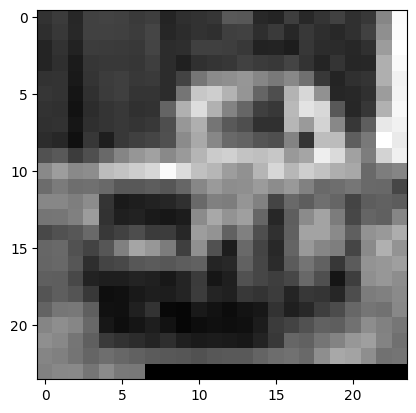

In [36]:
# plot batch
b = batch[0].view(1, 24, 24)
b = b.permute(1, 2, 0)
plt.imshow(b.numpy(), cmap='gray')

In [182]:
batch[0].requires_grad = True

In [148]:
batch[0][0:] = 0.0

In [183]:
output = nnet(batch[0].to(DEVICE))
loss = criterion(output, batch[1].to(DEVICE).squeeze())

In [184]:
# get gradient of loss with respect to input
grad = torch.autograd.grad(loss, batch[0], retain_graph=True)

(tensor(-0.7336), tensor(0.6561))

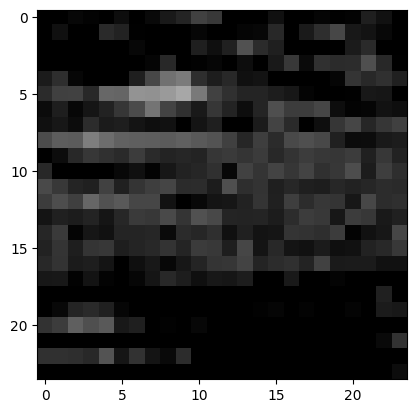

In [185]:
# visualize gradients


plt.imshow(grad[0].view(1, 24, 24).permute(1, 2, 0).cpu().numpy(), cmap='gray', vmin=0.0, vmax=1.0)

# color values
grad[0].min(), grad[0].max()


In [233]:
nnet.model[18].weight

Parameter containing:
tensor([[-0.1378, -0.1631, -0.1683,  ..., -0.1844, -0.2339, -0.1256],
        [-0.1533, -0.1123, -0.1025,  ..., -0.1367, -0.1252, -0.0897],
        [-0.0496, -0.1077, -0.1464,  ..., -0.1641, -0.1626, -0.1669],
        ...,
        [-0.0538, -0.0456, -0.1111,  ..., -0.1702, -0.1526, -0.1068],
        [-0.1186, -0.0678, -0.1432,  ..., -0.1685, -0.1811, -0.1210],
        [-0.0768, -0.0907, -0.2217,  ..., -0.1714, -0.1337, -0.0567]],
       device='cuda:0', requires_grad=True)

In [47]:
nnet = nnet.train()
nnet = nnet.to(DEVICE)

In [56]:
for epoch in range(1000000):
    for i, batch in enumerate(dataloader):
        #for repeat in range(10000):
            #or mask in range(0, 24*24):
            #batch = dataset.getspecific(i, mask)

        output = nnet(batch[0].to(DEVICE))
        target = batch[1].to(DEVICE)

        
        loss = criterion(output.squeeze(), target.squeeze())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        if len(losses) > 100:
            losses.pop(0)
        
        avg_loss = sum(losses) / len(losses)

        print(epoch, i, loss.item(), avg_loss, end="\r")
    
    total_losses.append(avg_loss)

KeyboardInterrupt: 

In [221]:
torch.save(nnet.state_dict(), open("./trained/autoregressor_on_72_images.pth", 'wb'))

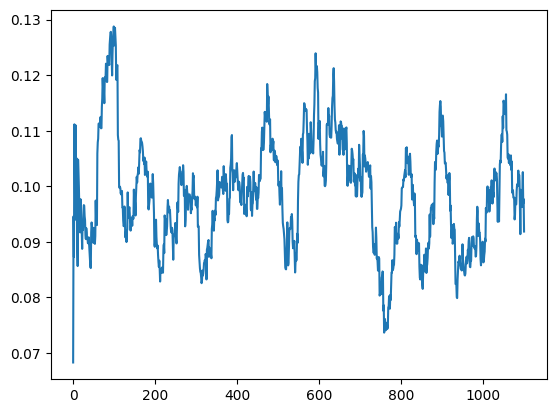

In [51]:
# one image - no batch norm - 512 hidden neurons - no biases
convnet_72_images = total_losses
# plot loss curve
plt.plot(convnet_72_images)


In [59]:
nnet = nnet.to("cpu")

In [328]:
import time

In [329]:
24 * 24

576

In [57]:
nnet = nnet.eval()

In [159]:
torch.softmax(output, 1)

tensor([[2.4651e-04, 1.4620e-04, 4.1019e-05, 1.4350e-05, 1.0715e-05, 8.8764e-09,
         3.4667e-05, 9.6201e-05, 1.1172e-04, 3.6593e-05, 1.5209e-04, 1.9212e-05,
         4.7483e-06, 4.0974e-05, 2.1691e-06, 6.4742e-05, 1.0564e-05, 1.4831e-04,
         5.8232e-05, 4.4486e-05, 9.5132e-05, 3.0346e-05, 2.5770e-04, 3.4669e-05,
         8.6378e-05, 3.2847e-05, 3.4642e-04, 1.1618e-04, 2.0425e-04, 2.2984e-04,
         2.0820e-01, 1.3486e-05, 5.5577e-04, 7.9301e-05, 1.4633e-03, 3.5823e-04,
         1.8335e-03, 1.4300e-04, 4.8210e-04, 4.5729e-04, 7.7048e-05, 2.0224e-04,
         4.2588e-04, 1.5281e-04, 5.4580e-04, 4.2805e-04, 1.5154e-03, 7.9290e-04,
         4.8028e-03, 9.1354e-02, 9.0551e-04, 4.0452e-05, 1.4332e-04, 2.3417e-04,
         1.5972e-03, 4.4603e-04, 1.0101e-04, 9.3893e-04, 1.4055e-02, 5.9447e-04,
         7.2976e-05, 2.8609e-02, 2.9116e-04, 1.2542e-04, 1.6880e-03, 4.2551e-02,
         2.9230e-04, 3.6470e-03, 3.5916e-04, 5.3543e-04, 5.0641e-04, 5.5929e-05,
         2.4788e-03, 5.6799e

In [61]:
# generate an image
outputs = []

for j in range(16):
    image = torch.zeros((1, 24*24))


    index = 0
    initial_index = index

    for i in range(24*24 - initial_index):
        #image[0][index] = -1.0

        with torch.no_grad():
            output = nnet(image.view((1, 1, 24, 24)))

        dist = torch.distributions.Categorical(torch.softmax(output, 1))

        norm_pixel_value = dist.sample() / 255.0

        #norm_pixel_value = torch.argmax(output).item() / 255.0

        image[0][index] = norm_pixel_value

        index += 1
        #print(image.shape)

        print(j, i, end="\r")

    #print(image)

    flattened = torch.flatten(image)
    bruv = flattened.view(1, 24, 24)
    bruv = bruv.permute(1, 2, 0)

    #print(image.min(), image.max())
    outputs.append(bruv.detach().numpy())

    #plt.imshow(bruv.detach().numpy())


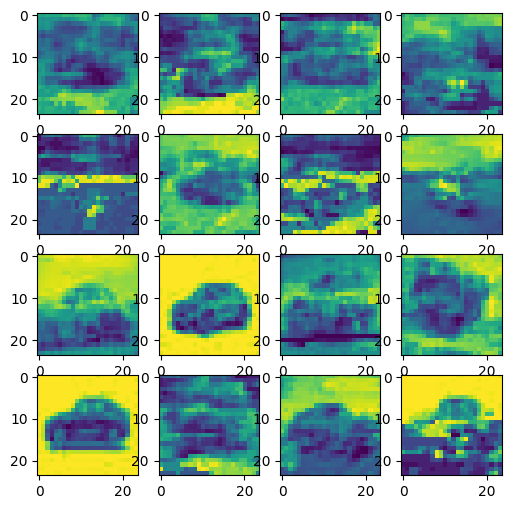

In [65]:
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(outputs[i*4+j])\

fig.savefig("./results/autoregressor_16_sampled_outputs.jpg")